In [75]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/customer-churn-dataset/customer_churn_dataset-testing-master.csv
/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv


In [76]:
!pip install numpy==1.22.4

In [115]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

## Exploratory Data Analysis (EDA) and Preprocessing 

In [78]:
train_data = pd.read_csv('/kaggle/input/customer-churn-dataset/customer_churn_dataset-testing-master.csv')
test_data = pd.read_csv('/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv')

In [79]:
train_data.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [80]:
train_data.drop('CustomerID',axis=1,inplace=True)
test_data.drop('CustomerID',axis=1,inplace=True)

In [81]:
#Null
print(train_data.isnull().sum())

print(test_data.isnull().sum())

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64


In [82]:
#Printing the isnull value 
test_data[test_data.isnull().any(axis=1)]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
#Drop the one entry 
test_data = test_data.dropna()
print(test_data.isnull().sum())

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


In [84]:
#Data Types
print(train_data.dtypes)
print(test_data.dtypes)

Age                   int64
Gender               object
Tenure                int64
Usage Frequency       int64
Support Calls         int64
Payment Delay         int64
Subscription Type    object
Contract Length      object
Total Spend           int64
Last Interaction      int64
Churn                 int64
dtype: object
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object


In [85]:
def convert_categorical(df):
    label_encoder = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = label_encoder.fit_transform(df[col])
    
    return df
    

In [86]:
# Label Encoding for columns of type 'object'
train_data = convert_categorical(train_data)


In [87]:
# Label Encoding for columns of type 'object'
test_data = convert_categorical(test_data)

print(test_data.dtypes)
test_data[test_data.select_dtypes(include='float').columns] = test_data.select_dtypes(include='float').astype('int64')
print(test_data.dtypes)

Age                  float64
Gender                 int64
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type      int64
Contract Length        int64
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object
Age                  int64
Gender               int64
Tenure               int64
Usage Frequency      int64
Support Calls        int64
Payment Delay        int64
Subscription Type    int64
Contract Length      int64
Total Spend          int64
Last Interaction     int64
Churn                int64
dtype: object


In [88]:
train_data.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22,0,25,14,4,27,0,1,598,9,1
1,41,0,28,28,7,13,2,1,584,20,0
2,47,1,27,10,2,29,1,0,757,21,0
3,35,1,9,12,5,17,1,2,232,18,0
4,53,0,58,24,9,2,2,0,533,18,0


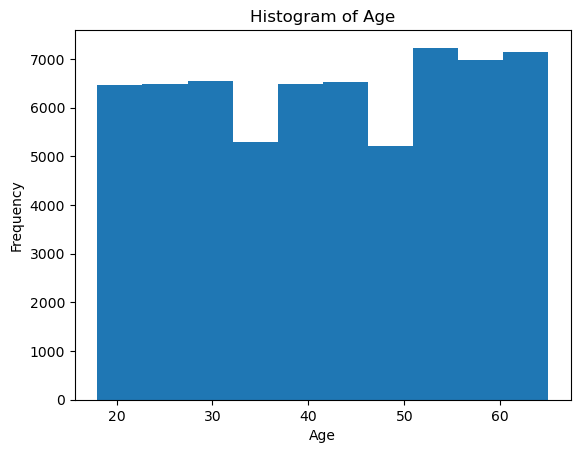

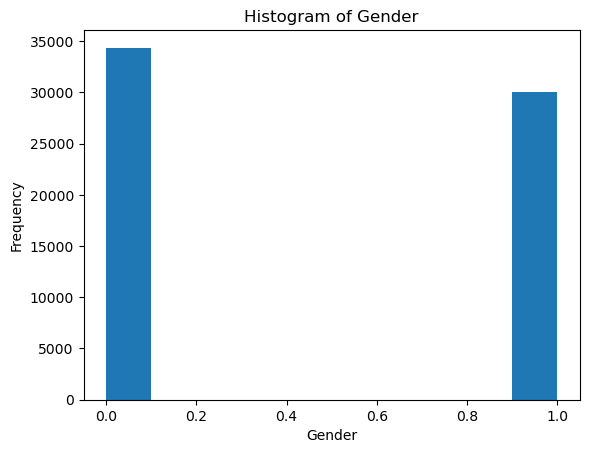

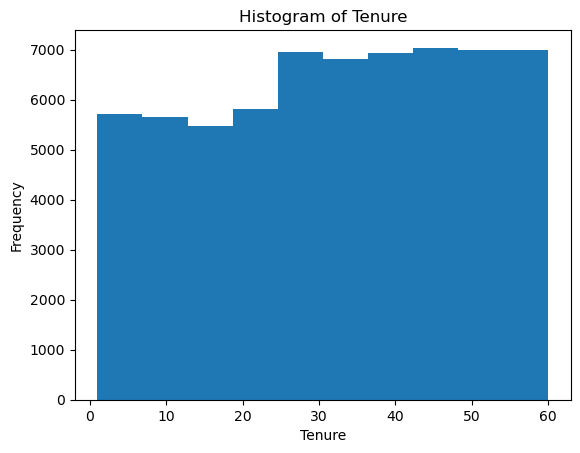

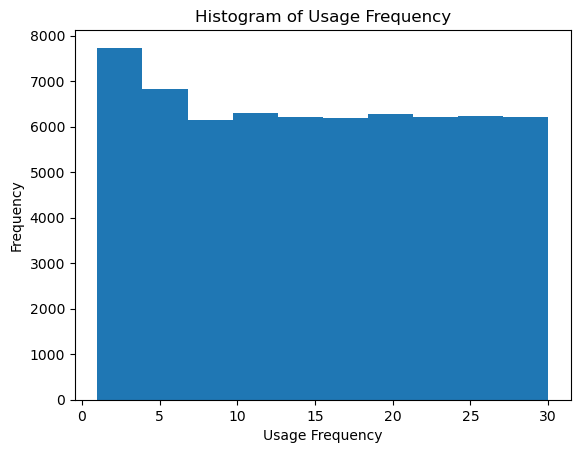

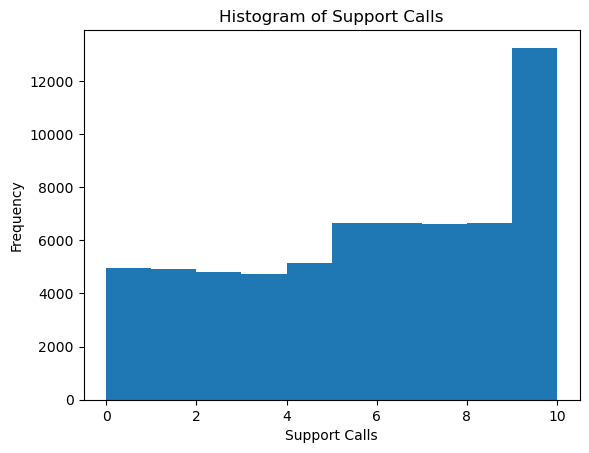

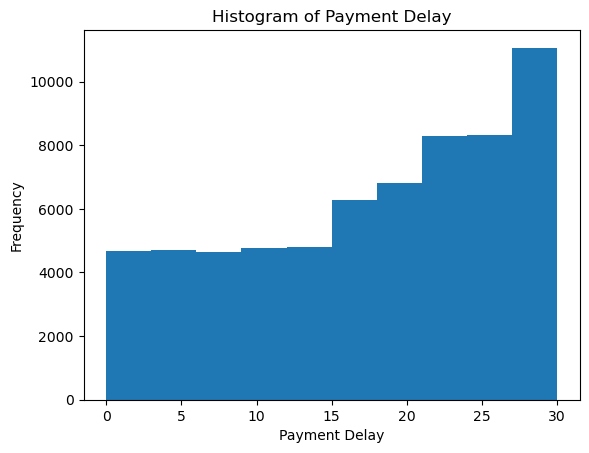

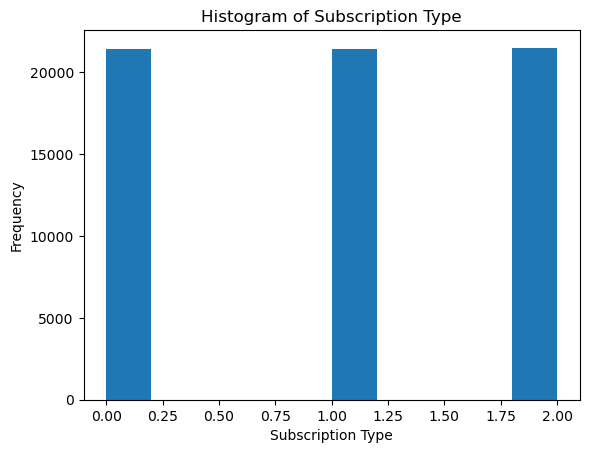

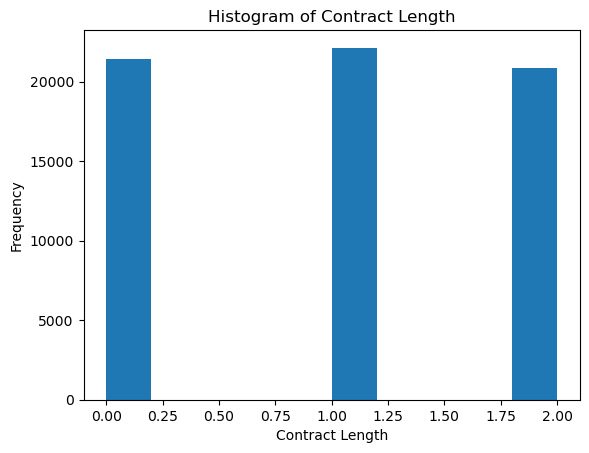

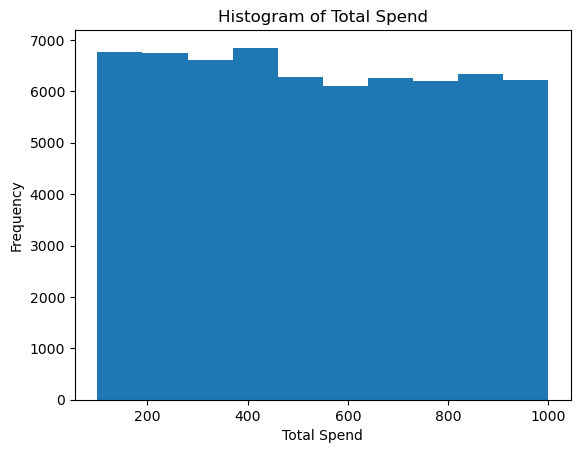

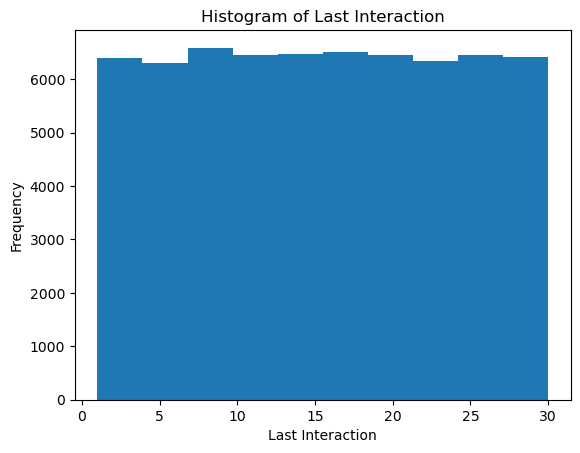

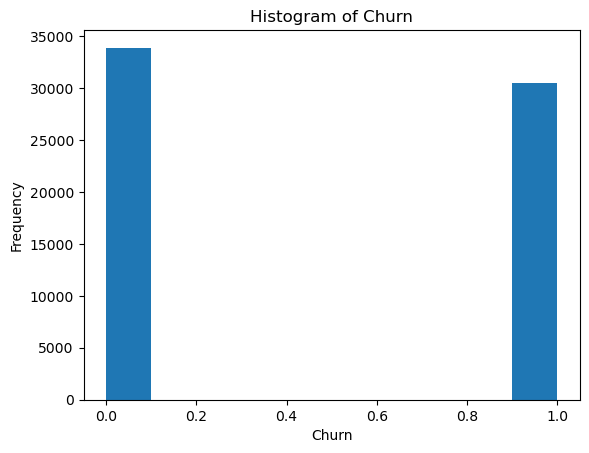

In [89]:
for col in train_data.columns:
  plt.hist(train_data[col])
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.title('Histogram of {}'.format(col))
  plt.show()

In [90]:
#Finally, checking if churn is balanced
print('Distribution of churn rates')
print(train_data.Churn.value_counts())

Distribution of churn rates
0    33881
1    30493
Name: Churn, dtype: int64


## Feature Selection 

In [91]:
X = train_data.drop('Churn',axis=1)
y = train_data.Churn

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(dual=False,penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', RandomForestClassifier())])

In [92]:
pred_1 = test_data[[ 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction']]

actual = test_data.Churn

pred_clf = clf.predict(pred_1)
accuracy_score(actual, pred_clf)

0.5836962833914053

In [93]:
clf = Pipeline([
  ('scaler', StandardScaler()),
  ('classification', RandomForestClassifier())
])

In [96]:
clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classification', RandomForestClassifier())])

In [97]:
scaler = StandardScaler()
x_test = test_data.drop('Churn',axis=1)
pred_1 = scaler.fit_transform(x_test)

actual = test_data.Churn

pred_clf = clf.predict(pred_1)
accuracy_score(actual, pred_clf)

0.5793885198896632

In [98]:
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('XGB', XGBClassifier())
])

pipe.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [99]:
scaler = StandardScaler()
x_test = test_data.drop('Churn',axis=1)
pred_1 = scaler.fit_transform(x_test)
actual = test_data.Churn

pred_clf = pipe.predict(pred_1)
accuracy_score(actual, pred_clf)

0.5793885198896632

In [100]:
X = train_data.drop('Churn',axis=1)
y = train_data.Churn

XGB = XGBClassifier()
XGB.fit(X,np.ravel(y))
y_hat = XGB.predict(test_data.drop('Churn',axis=1))
accuracy_score(test_data.Churn,y_hat)

0.583621424941928

In [104]:
#Last model will use the feature selection method with XGBoost
X = train_data.drop('Churn',axis=1)
y = train_data.Churn

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(dual=False,penalty="l1"))),
  ('scaler',StandardScaler()),
  ('classification', XGBClassifier())
])
clf.fit(X, y)

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('scaler', StandardScaler()),
                ('classification',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_ty...e,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [107]:
pred_1 = test_data[[ 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction']]

scaler = StandardScaler()
pred_1 = scaler.fit_transform(pred_1)

pred_clf = clf.predict(pred_1)
accuracy_score(actual, pred_clf)

0.5793885198896632

## Using on the Training Data to See how the Model Performs

In [108]:
X = train_data.iloc[:,:-1]
X.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
0,22,0,25,14,4,27,0,1,598,9
1,41,0,28,28,7,13,2,1,584,20
2,47,1,27,10,2,29,1,0,757,21
3,35,1,9,12,5,17,1,2,232,18
4,53,0,58,24,9,2,2,0,533,18


In [110]:
y = train_data.iloc[:,-1:]
y.head()

,Churn
0,1
1,0
2,0
3,0
4,0


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
XGB = XGBClassifier()
XGB.fit(X_train, np.ravel(y_train))
y_hat = XGB.predict(X_test)

print(accuracy_score(y_test, y_hat))

1.0


In [114]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6793
           1       1.00      1.00      1.00      6082

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875



While the model does well with just the training data- be congncent that overfitting may have occured.